In [229]:
import numpy as np
import qutip as qt
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
from qbism import sic_povm

In [256]:
?qt.rand_dm_ginibre

Signature: qt.rand_dm_ginibre(N=2, rank=None, dims=None, seed=None)
Docstring:
Returns a Ginibre random density operator of dimension
``dim`` and rank ``rank`` by using the algorithm of
[BCSZ08]_. If ``rank`` is `None`, a full-rank
(Hilbert-Schmidt ensemble) random density operator will be
returned.

Parameters
----------
N : int
    Dimension of the density operator to be returned.
dims : list
    Dimensions of quantum object.  Used for specifying
    tensor structure. Default is dims=[[N],[N]].

rank : int or None
    Rank of the sampled density operator. If None, a full-rank
    density operator is generated.

Returns
-------
rho : Qobj
    An N × N density operator sampled from the Ginibre
    or Hilbert-Schmidt distribution.
File:      ~/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/qutip/random_objects.py
Type:      function

In [291]:

N = 1000
initial_rho_array = jnp.array([qt.rand_dm_ginibre(2) for _ in range(N)])

In [292]:
initial_rho_array.shape

(1000, 2, 2)

In [21]:
initial_rho0 = jnp.array(qt.rand_dm(2, seed=8).full())
initial_rho0

Array([[0.6205978 +0.j        , 0.2705438 -0.13533728j],
       [0.2705438 +0.13533728j, 0.37940222+0.j        ]], dtype=complex64)

In [17]:
@jit
def vec(A):
    return A.flatten()

In [270]:
@jit
def generate_map(G):
    g_of_t = G
    return jnp.array(
        [
            [jnp.conjugate(g_of_t) * g_of_t, 0, 0, 0],
            [0, g_of_t, 0, 0],
            [0, 0, jnp.conjugate(g_of_t), 0],
            [1 - jnp.conjugate(g_of_t) * g_of_t, 0, 0, 1],
        ]
    )

In [271]:
@jit
def G(t, lamda, gamma_0):
    delta = jnp.sqrt((1 - 2 * gamma_0 / lamda) + 1j*0)
    return jnp.exp(-lamda * t / 2) * (
        jnp.cosh(lamda * t / 2 * delta)
        + 1 / delta * jnp.sinh(lamda * t / 2 * delta)
    )

In [293]:
@jit
def name_of_fun(
    initial_state,
    sic_povm_array,
    times_array,
    lamda,
    gamma_0,
):
    evolved_rho = jax.vmap(
        lambda t: generate_map(G(t, lamda, gamma_0)) @ vec(initial_state)
    )(times_array)

    evolved_probabilities = jax.vmap(
        lambda rho: jnp.einsum("kj, ijk", rho.reshape(2, 2), sic_povm_array)
    )(evolved_rho)

    return evolved_probabilities

In [283]:
sic_array = jnp.array(sic_povm(2))

(500, 4)

In [296]:
lamda = 0.8
# gamma_0 = 0.8 * lamda / 2  # weak coupling
gamma_0 = 20 * lamda / 2  # strong coupling


times = np.linspace(0, 10, 5000)

initial_rho0 = jnp.array(qt.rand_dm(2, seed=8).full())

sic_array = jnp.array(sic_povm(2))


# jax.jit(name_of_fun)(initial_rho0, sic_array, times, lamda, gamma_0)

evolved_probabilities_array = (jax.vmap(lambda rho_i:(name_of_fun)(rho_i, sic_array, times, lamda, gamma_0) )(initial_rho_array))

In [303]:
import joblib

data_to_save = {
    "lambda": lamda,
    "gamma_0": gamma_0,
    "times": times,
    "Initial_rhos": initial_rho_array,
    "povm_arr": sic_array,
    "prob arr": evolved_probabilities_array,
}

joblib.dump(data_to_save, "first_dataset.job", compress=0)

['first_dataset.job']

/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/jax/_src/array.py:407: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


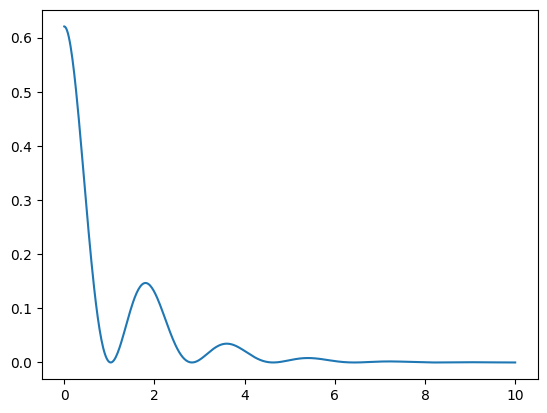

In [273]:
times = np.linspace(0, 10, 500)


evolved_rho = (jax.vmap(
    lambda t: generate_map(G(t, lamda, gamma_0))
    @ vec(initial_rho0)
)(times))


# for i in range(4):
#     plt.plot(times, evolved_rho[:, i])
plt.plot(times, evolved_rho[:, 0])
# plt.plot(times, evolved_rho[:, 3])
plt.show()


In [274]:
evolved_probabilities = jax.vmap(lambda rho: jnp.einsum('kj, ijk', rho.reshape(2, 2), jnp.array(sic_povm(2))))(evolved_rho)

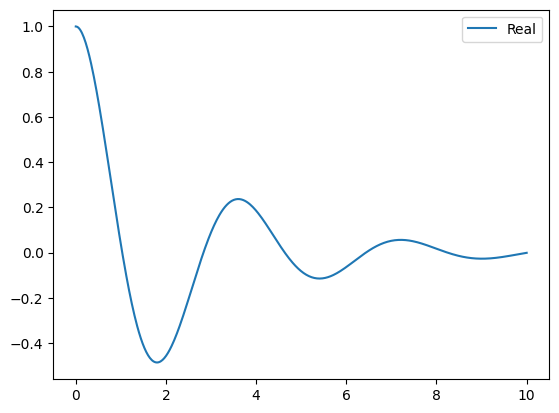

In [275]:
plt.plot(
    times,
    jnp.real((jax.vmap(lambda t: G(t, lamda, gamma_0)))(times)),
    label="Real",
)
plt.legend()
plt.show()

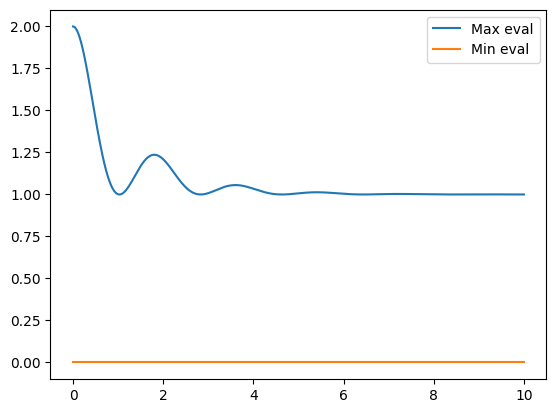

In [277]:


eigenvecs_time = jax.vmap(
    lambda t: jnp.linalg.eigh(
        generate_map(G(t, lamda, gamma_0))
        .reshape(2, 2, 2, 2)
        .swapaxes(1, 2)
        .reshape(4, 4)
    )[0]
)(times)
min_mal_evals = jnp.array(
    jax.vmap(lambda a: [jnp.min(a), jnp.max(a)])(eigenvecs_time)
)

plt.plot(times, min_mal_evals[1], label="Max eval")
plt.plot(times, min_mal_evals[0], label="Min eval")
plt.legend()
plt.show()

# Superoperator part

In [307]:
omega_0 = 1

H = (omega_0*qt.sigmap()*qt.sigmam()).full()

In [309]:
def dag(A):
    return jnp.conjugate(A.T)


def sprepost(A, B):
    return jnp.kron(A, jnp.transpose(B))


def spre(A):
    return sprepost(A, jnp.identity(2))


def spost(A):
    return sprepost(jnp.identity(2), A)


In [313]:
naked_dissipator = sprepost(
    qt.sigmam().full(), qt.sigmam().dag().full()
) - 0.5 * (
    spre((qt.sigmap() * qt.sigmam()).full())
    + spost((qt.sigmap() * qt.sigmam()).full())
)

naked_dissipator

Array([[-1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j],
       [ 1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j]], dtype=complex64)